Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from concurrent.futures import ThreadPoolExecutor

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Loading and Visualising the Training Data

In [5]:

images_path = 'dataset\\ODIR-5K\\Training Images\\'
images = []
labels = []

def load_process_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_image_result(result):
    img, label = result
    if img is not None:
        images.append(img)
        labels.append(label)

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in df_data.iterrows():
        left_image_path = images_path + row['Left-Fundus']
        right_image_path = images_path + row['Right-Fundus']
        futures.append(executor.submit(load_process_image, left_image_path, row['Left-Diagnostic Keywords']))
        futures.append(executor.submit(load_process_image, right_image_path, row['Right-Diagnostic Keywords']))
    
    for future in futures:
        handle_image_result(future.result())

images = np.array(images)
labels = np.array(labels)


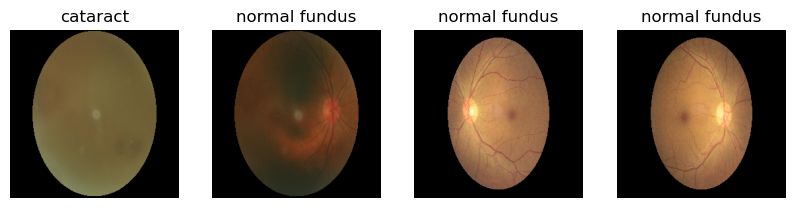

In [6]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i] / 255)
    plt.title(labels[i])
    plt.axis('off')

plt.show()


Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, O have low image samples, thus need for balancing these classes is required.

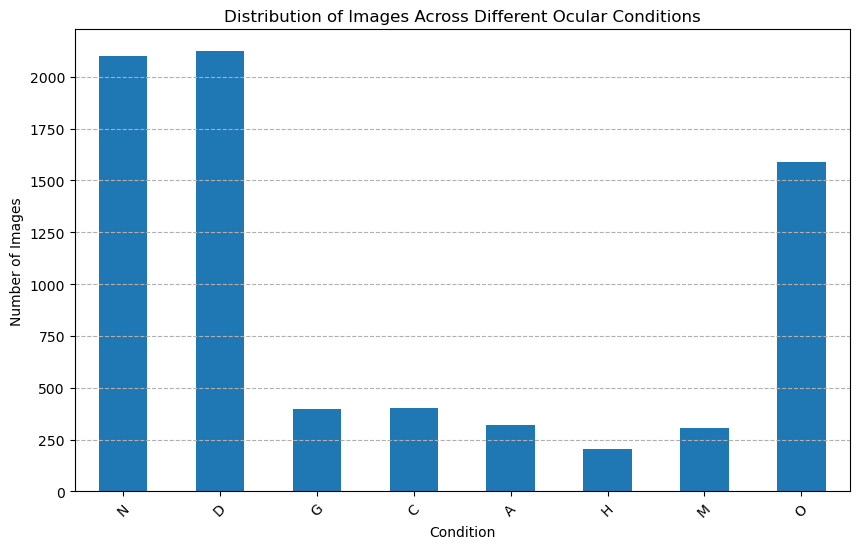

In [7]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [8]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Dealing with class imbalance - Calculating class weights 
- This one approach to resolving the class imbalance, the class weights calculated will make the CNN model more sensitive to underrepresented classes and improve its overall performance on imbalanced datasets. Higher class weight will mean that a single sample from a higher weight class would be considered as 7 samples from a class with lower weights. 


In [9]:
# The dataset is imbalanced, so we will use class weights to balance it out during training                     
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / class_counts[0],
    1: total_samples / class_counts[1],
    2: total_samples / class_counts[2],
    3: total_samples / class_counts[3],
    4: total_samples / class_counts[4],
    5: total_samples / class_counts[5],
    6: total_samples / class_counts[6],
    7: total_samples / class_counts[7]
}       

Loading and Visualising the Imbalanced Target Classes 

In [61]:
images_path = 'dataset/ODIR-5K/Training Images/'  # Adjusted for consistency
target_classes = ['G', 'C', 'A', 'H', 'M', 'O']

target_images = []
target_labels = []

def load_process_target_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(64, 64))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_target_image_result(result):
    img, label = result
    if img is not None:
        target_images.append(img)
        target_labels.append(label)

# Use ThreadPoolExecutor to load and process images that match target_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in df_data.iterrows():
        # For each target class, check if the condition is present for either eye
        for target_class in target_classes:
            if target_class in row and row[target_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[target_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    futures.append(executor.submit(load_process_target_image, left_image_path, (row['Left-Diagnostic Keywords'])))
                if 'Right-Fundus' + target_class in row and row[target_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    futures.append(executor.submit(load_process_target_image, right_image_path, (row['Right-Diagnostic Keywords'])))
    
    
    for future in futures:
        handle_target_image_result(future.result())

# Convert to NumPy arrays
target_images = np.array(target_images)
target_labels = np.array(target_labels)



c:\Users\duwak\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


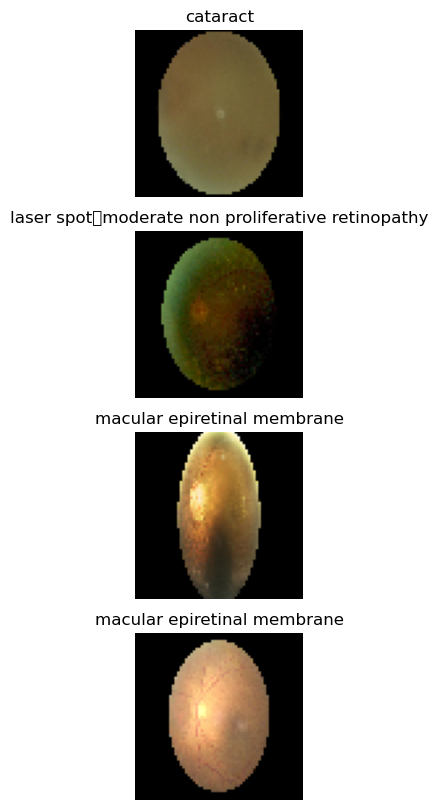

In [62]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(4,1,i+1)
    plt.imshow(target_images[i] / 255)
    plt.title(target_labels[i])
    plt.axis('off')

plt.show()


Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 

In [63]:
# Assuming df_data is your DataFrame and images_path is defined
# Define the augmentation parameters
augmentation = ImageDataGenerator(
    rotation_range=40,  # Increased rotation range to 40 degrees
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # Added brightness range for noise
    channel_shift_range=50,  # Added channel shift range for noise
    fill_mode='nearest'  # Filling mode for augmented images
)

# Initialize lists to store augmented images and labels
augmented_images = []
augmented_labels = []

for img, label in zip(target_images, target_labels):
    # Original image
    augmented_images.append(img)
    augmented_labels.append(label)
    
    # Augmented image with noise
    img_augmented = augmentation.random_transform(img)
    augmented_images.append(img_augmented)
    augmented_labels.append(label)

# Convert the list of images to a NumPy array
augmented_images = np.array(augmented_images)



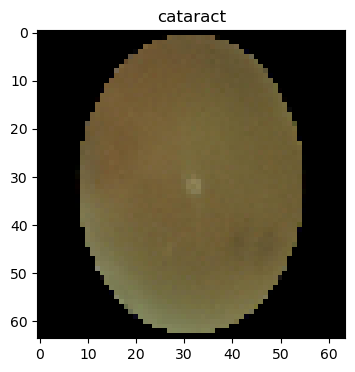

In [64]:
# Display the first augmented image and its label, if available
if len(augmented_images) > 0:
    plt.figure(figsize=(4,4))
    plt.imshow(augmented_images[0] / 255.0)  # Normalize the image
    plt.title(augmented_labels[0])
    plt.show()
else:
    print("No augmented images were created.")

Dealing with Class Imbalance - CGANs synthetic image generation
- Using Conditional Generative Adversarial Networks to generate synthetic images for underrespresented classes in the dataset. 

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [65]:
def build_discriminator(img_shape, num_classes):
    # Input layer for the image
    img = Input(shape=img_shape)
    
    # Input layer for the label
    label = Input(shape=(1,), dtype='int32')
    
    # Embedding for the label, reshaped to match image dimensions
    label_embedding = Embedding(num_classes, np.prod(img_shape))(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Dense(np.prod(img_shape), activation='relu')(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    # Combine image and label
    combined_input = multiply([img, label_embedding])
    
    # Now define the discriminator model
    x = Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same')(combined_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    validity = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[img, label], outputs=validity)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16384)             1654784   
                                                                 
 reshape_10 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_15 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_26 (Conv2  (None, 16, 16, 128)       524416    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 16, 16, 128)     

1/1 [==============================] - 0s 33ms/step
0 [D loss: 6.526723161925929e-09, acc.: 100.0] [G loss: 18.155231475830078]
1/1 [==============================] - 0s 32ms/step
100 [D loss: 5.961028115564204e-09, acc.: 100.0] [G loss: 18.243907928466797]
1/1 [==============================] - 0s 30ms/step
200 [D loss: 5.39965627766037e-09, acc.: 100.0] [G loss: 18.34349822998047]
1/1 [==============================] - 0s 32ms/step
300 [D loss: 4.8789665640924795e-09, acc.: 100.0] [G loss: 18.446762084960938]
1/1 [==============================] - 0s 33ms/step
400 [D loss: 4.4343071436969694e-09, acc.: 100.0] [G loss: 18.544029235839844]
1/1 [==============================] - 0s 30ms/step
500 [D loss: 3.981465379609972e-09, acc.: 100.0] [G loss: 18.65035057067871]
1/1 [==============================] - 0s 32ms/step
600 [D loss: 3.646644985977332e-09, acc.: 100.0] [G loss: 18.73615074157715]
1/1 [==============================] - 0s 31ms/step
700 [D loss: 3.2989835307972726e-09, acc.:

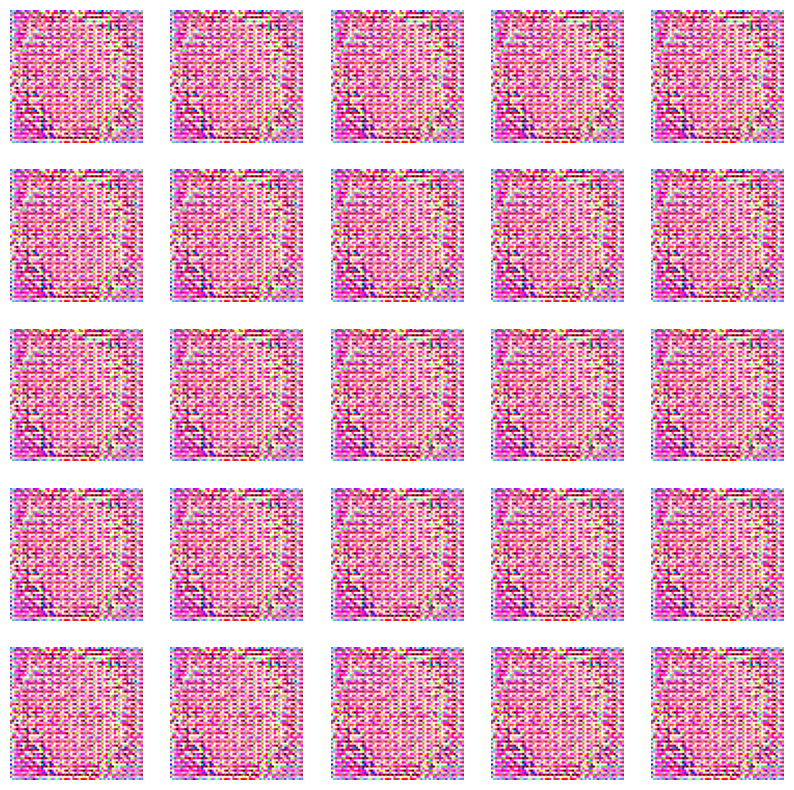

In [72]:
# Define the training procedure
def train_gan(gan, generator, discriminator, target_images, z_dim, epochs=100, batch_size=32):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, target_images.shape[0], half_batch)
        imgs = target_images[idx]
        noise = np.random.normal(0, 1, (half_batch, z_dim))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        # Progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

# Placeholder for generator, discriminator, and gan models
# Ensure these models are defined and compiled as per the GAN structure discussed earlier

z_dim = 100  # Dimension of the noise vector
train_gan(gan, generator, discriminator, target_images, z_dim, epochs=10000, batch_size=32)

# Generate images (Example placeholder)
noise = np.random.normal(0, 1, (25, z_dim))
generated_images = generator.predict(noise)

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    # Adjust image normalization if necessary
    plt.imshow((generated_images[i, :, :, :] + 1) / 2)
    plt.axis('off')
plt.show()

# Resize the images
generated_images_resized = tf.image.resize(generated_images, size=[256, 256]).numpy()

Improving the efficiency of the dataset
- One-hot encoding for machine learning purposes may not be most efficient for multi-label classification hence to improve the efficiency of this dataset the individual one-hot encoded columns will be converted into a single list also known as multi-hot encoding. 